In [7]:
import fastf1
import pandas as pd
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Configuration
DATA_FILENAME = 'f1_undercut_data_full.csv'

# 1. Define the folder name
cache_folder_name = 'cache'

# 2. CRITICAL STEP: Create the folder if it doesn't exist yet
if not os.path.exists(cache_folder_name):
    os.makedirs(cache_folder_name)

# 3. Now it is safe to enable the cache
fastf1.Cache.enable_cache(cache_folder_name) 

print("Cache enabled successfully!")

Cache enabled successfully!


In [8]:
def process_season(year):
    print(f"\n--- PROCESSING SEASON {year} ---")
    try:
        schedule = fastf1.get_event_schedule(year)
    except Exception as e:
        print(f"Error fetching schedule for {year}: {e}")
        return []

    season_data = []
    # Get only official races
    races = schedule[schedule['RoundNumber'] > 0]
    
    for _, race_event in races.iterrows():
        round_num = race_event['RoundNumber']
        gp_name = race_event['EventName']
        
        print(f"  > Loading Round {round_num}: {gp_name}...")
        
        try:
            # Load session (telemetry=False for speed)
            session = fastf1.get_session(year, round_num, 'R')
            session.load(telemetry=False, weather=False, messages=False)
            
            if session.laps.empty:
                print("    [Skipped] No lap data found.")
                continue
                
            # Process the race
            race_dataset = process_race_laps(session.laps, year, gp_name)
            season_data.extend(race_dataset)
            
            # Sleep to respect API rate limits
            time.sleep(2) 
            
        except Exception as e:
            print(f"    [Error] Could not process {gp_name}: {e}")
            time.sleep(2)
            continue
            
    return season_data

def process_race_laps(laps, year, gp_name):
    race_data = []
    
    # Safety check: Ensure PitOutTime exists
    if 'PitOutTime' not in laps.columns: return []

    pit_laps_only = laps[laps['PitOutTime'].notna()]
    if pit_laps_only.empty: return []
    
    # Calc average pit lap for Aggressiveness feature
    avg_pit_lap = pit_laps_only.groupby('Compound')['LapNumber'].mean()
    
    drivers = laps['Driver'].unique()
    
    for drv in drivers:
        drv_laps = laps[laps['Driver'] == drv]
        pit_laps = drv_laps[drv_laps['PitOutTime'].notna()]['LapNumber'].tolist()
        
        for pit_lap in pit_laps:
            # --- FEATURE ENGINEERING ---
            
            # 1. State Reconstruction (Lap BEFORE pit)
            pre_pit_lap = pit_lap - 1
            if pre_pit_lap < 1: continue 
            
            try:
                # Fast Scalar Access
                my_state_mask = (laps['Driver'] == drv) & (laps['LapNumber'] == pre_pit_lap)
                if not my_state_mask.any(): continue
                my_state = laps.loc[my_state_mask].iloc[0]
                
                my_pos = my_state['Position']
                my_compound = my_state['Compound']
            except IndexError: continue
                
            # 2. Rival Identification (Car directly ahead)
            rival_pos = my_pos - 1
            if rival_pos < 1: continue 
            
            rival_mask = (laps['LapNumber'] == pre_pit_lap) & (laps['Position'] == rival_pos)
            if not rival_mask.any(): continue
            rival_state_row = laps.loc[rival_mask]
            
            rival_driver = rival_state_row.iloc[0]['Driver']
            rival_laps = laps[laps['Driver'] == rival_driver]
            
            # 3. Calculate Core Features
            gap_to_ahead = (my_state['Time'] - rival_state_row.iloc[0]['Time']).total_seconds()
            pace_delta = my_state['LapTime'].total_seconds() - rival_state_row.iloc[0]['LapTime'].total_seconds()
            rival_tyre_age = rival_state_row.iloc[0]['TyreLife']
            
            # Aggressiveness
            if my_compound in avg_pit_lap:
                aggression = avg_pit_lap[my_compound] - pit_lap
            else:
                aggression = 0
            
            # Execution Metrics
            pit_lap_mask = (laps['Driver'] == drv) & (laps['LapNumber'] == pit_lap)
            if not pit_lap_mask.any(): continue
            pit_lap_data = laps.loc[pit_lap_mask].iloc[0]
            
            # Handle missing PitStopDuration safely
            if 'PitStopDuration' in pit_lap_data and pd.notna(pit_lap_data['PitStopDuration']):
                stationary_duration = pit_lap_data['PitStopDuration']
            else:
                stationary_duration = np.nan 
            
            in_lap_sec = pit_lap_data['LapTime'].total_seconds()
            
            out_lap_mask = (laps['Driver'] == drv) & (laps['LapNumber'] == pit_lap + 1)
            if not out_lap_mask.any(): continue
            out_lap_sec = laps.loc[out_lap_mask].iloc[0]['LapTime'].total_seconds()

            # 4. Undercut Definition
            rival_pit_window = range(int(pit_lap) + 1, int(pit_lap) + 6)
            rival_pit_row = rival_laps[rival_laps['LapNumber'].isin(rival_pit_window) & (rival_laps['PitOutTime'].notna())]
            
            is_undercut_attempt = not rival_pit_row.empty
            
            success = 0
            if is_undercut_attempt:
                rival_pit_lap_num = rival_pit_row.iloc[0]['LapNumber']
                
                my_post_mask = (laps['Driver'] == drv) & (laps['LapNumber'] == rival_pit_lap_num)
                rival_post_mask = (laps['Driver'] == rival_driver) & (laps['LapNumber'] == rival_pit_lap_num)
                
                if my_post_mask.any() and rival_post_mask.any():
                    my_new_pos = laps.loc[my_post_mask].iloc[0]['Position']
                    rival_new_pos = laps.loc[rival_post_mask].iloc[0]['Position']
                    # Success if my position is numerically lower (better) than rival
                    success = 1 if my_new_pos < rival_new_pos else 0
            
            race_data.append({
                'Year': year,
                'GP': gp_name,
                'Driver': drv,
                'Rival': rival_driver,
                'Gap_To_Ahead': gap_to_ahead,
                'Rival_Tyre_Age': rival_tyre_age,
                'Pace_Delta': pace_delta,
                'Pit_Aggressiveness': aggression,
                'StationaryDuration': stationary_duration,
                'InLap_Sec': in_lap_sec,
                'OutLap_Sec': out_lap_sec,
                'is_undercut': 1 if is_undercut_attempt else 0,
                'undercut_successful': success
            })
            
    return race_data

In [9]:
if os.path.exists(DATA_FILENAME):
    print(f"✅ Found existing data file: {DATA_FILENAME}")
    print("   Loading data directly from CSV...")
    df = pd.read_csv(DATA_FILENAME)
    
else:
    print(f"❌ File {DATA_FILENAME} not found.")
    print("   Starting fresh download from FastF1 (2022-2024)...")
    print("   (This may take 30-45 minutes. Please wait.)")
    
    all_data = []
    # You can add more years here if you want
    years = [2022, 2023, 2024]

    for yr in years:
        all_data.extend(process_season(yr))
    
    if len(all_data) > 0:
        df = pd.DataFrame(all_data)
        
        # --- SAVING TO CSV ---
        print(f"💾 Saving processed data to {DATA_FILENAME}...")
        df.to_csv(DATA_FILENAME, index=False)
        print("   Save complete.")
    else:
        print("⚠️ No data was collected. Check internet/API status.")
        df = pd.DataFrame()

✅ Found existing data file: f1_undercut_data_full.csv
   Loading data directly from CSV...


In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
if not df.empty:
    print("\n--- Training Undercut Predictor ---")
    
    # 1. Filter: Train ONLY on rows where an undercut was actually attempted
    df_model = df[df['is_undercut'] == 1].copy()
    
    if len(df_model) == 0:
        print("No undercut attempts found in the dataset.")
    else:
        # 2. Data Cleaning
        # Fill missing stationary times with average (approx 2.5s)
        df_model['StationaryDuration'] = df_model['StationaryDuration'].fillna(2.5)
        
        # Remove rows where critical timing data is missing
        df_model.dropna(subset=['InLap_Sec', 'OutLap_Sec', 'Gap_To_Ahead'], inplace=True)
        
        print(f"Training on {len(df_model)} confirmed undercut attempts.")
        
        CORE_FEATURES = [
            'Gap_To_Ahead',
            'Rival_Tyre_Age',
            'Pace_Delta',
            'Pit_Aggressiveness',
            'StationaryDuration',
            'InLap_Sec',
            'OutLap_Sec'
        ]
        
        X = df_model[CORE_FEATURES]
        y = df_model['undercut_successful']
        
        # 3. Train/Test Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # 4. Model Training
        clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
        clf.fit(X_train, y_train)
        
        # 5. Evaluation
        print("\n--- Model Performance ---")
        y_pred = clf.predict(X_test)
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred_constrained)
        print(cm)

        # Visualization
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Failed', 'Successful'],
                    yticklabels=['Failed', 'Successful'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix: Undercut Prediction')
        plt.show()
        
        print("\n--- Feature Importance ---")
        importances = pd.Series(clf.feature_importances_, index=CORE_FEATURES).sort_values(ascending=False)
        print(importances)
else:
    print("Script finished without data.")


--- Training Undercut Predictor ---
Training on 592 confirmed undercut attempts.

--- Model Performance ---
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        58
           1       0.83      0.89      0.86        61

    accuracy                           0.85       119
   macro avg       0.85      0.85      0.85       119
weighted avg       0.85      0.85      0.85       119


--- Feature Importance ---
Gap_To_Ahead          0.415833
Pace_Delta            0.157089
OutLap_Sec            0.119343
Pit_Aggressiveness    0.114323
InLap_Sec             0.108539
Rival_Tyre_Age        0.084872
StationaryDuration    0.000000
dtype: float64


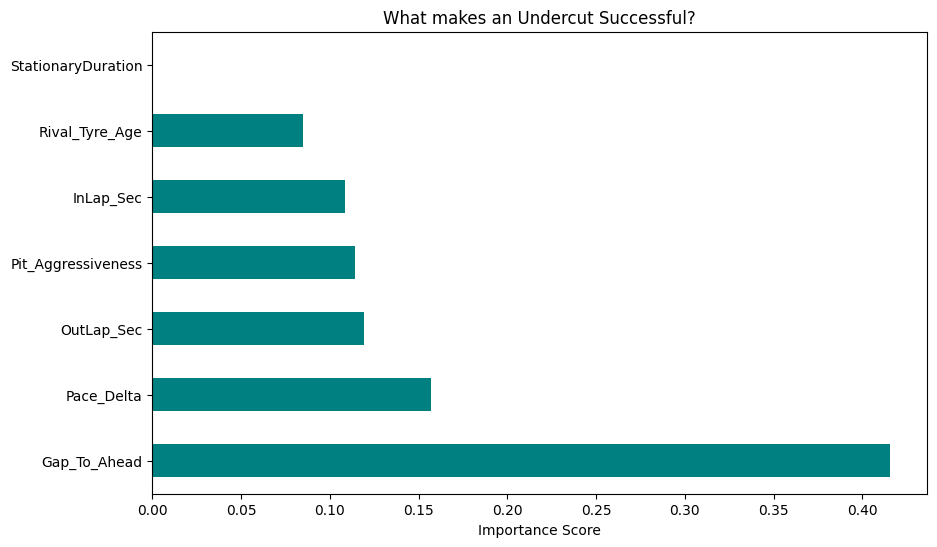

In [11]:
import matplotlib.pyplot as plt

if 'importances' in locals():
    plt.figure(figsize=(10, 6))
    importances.plot(kind='barh', color='teal')
    plt.title('What makes an Undercut Successful?')
    plt.xlabel('Importance Score')
    plt.show()